# Hyper param exploration

http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_gp.ipynb

## Imports etc...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
np.set_printoptions(linewidth=1000)

mpl.rcParams.update({
    "figure.dpi": 200,                    
    "font.size": 10,
    # Ticks
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": False,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": False,
    "lines.linewidth" : 0.8,
    "lines.markersize" : 3,


})

# Unconstrained examples with varying hyperparams

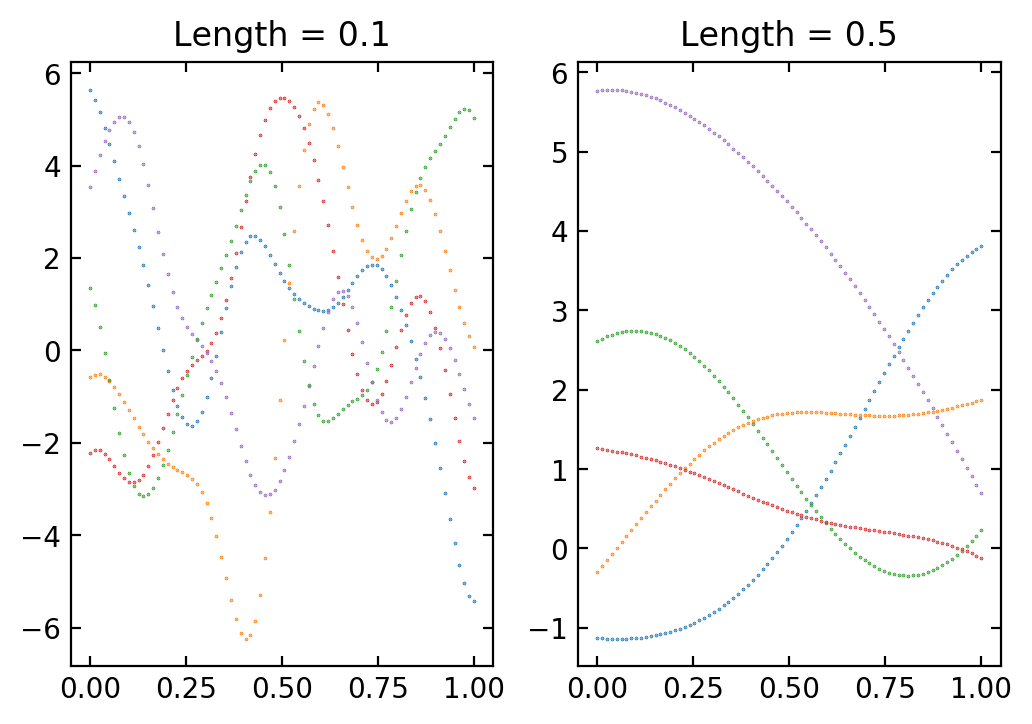

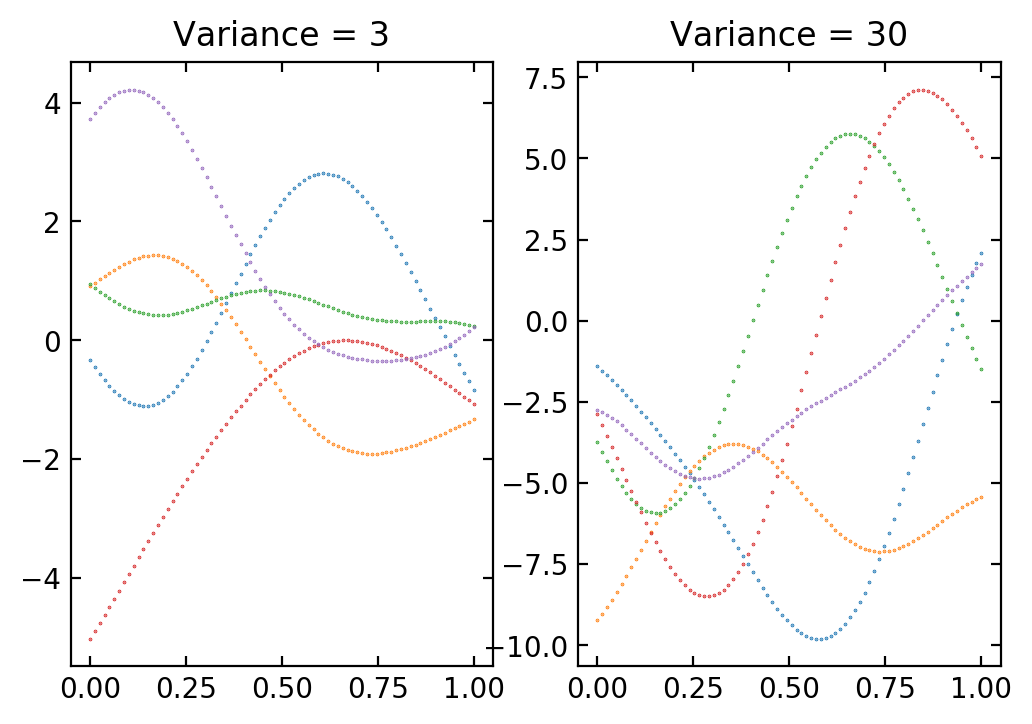

In [3]:
num_pts = 80
x = np.linspace(0, 1, num_pts)
x = np.expand_dims(x, 1)
_, axes = plt.subplots(1, 2)


for i, ls in enumerate([0.1, 0.5]):
    k = GPy.kern.RBF(1, variance=7., lengthscale=ls)

    for _ in range(5):
        f = np.random.multivariate_normal(np.zeros(num_pts), k.K(x))
        axes[i].scatter(x, f, s=0.1)

    axes[i].set(title="Length = {}".format(ls))
    
    
_, axes = plt.subplots(1, 2)


for i, var in enumerate([3, 30]):
    k = GPy.kern.RBF(1, variance=var, lengthscale=0.3)

    for _ in range(5):
        f = np.random.multivariate_normal(np.zeros(num_pts), k.K(x))
        axes[i].scatter(x, f, s=0.1)

    axes[i].set(title="Variance = {}".format(var))

# Constrained with varying hyperparams

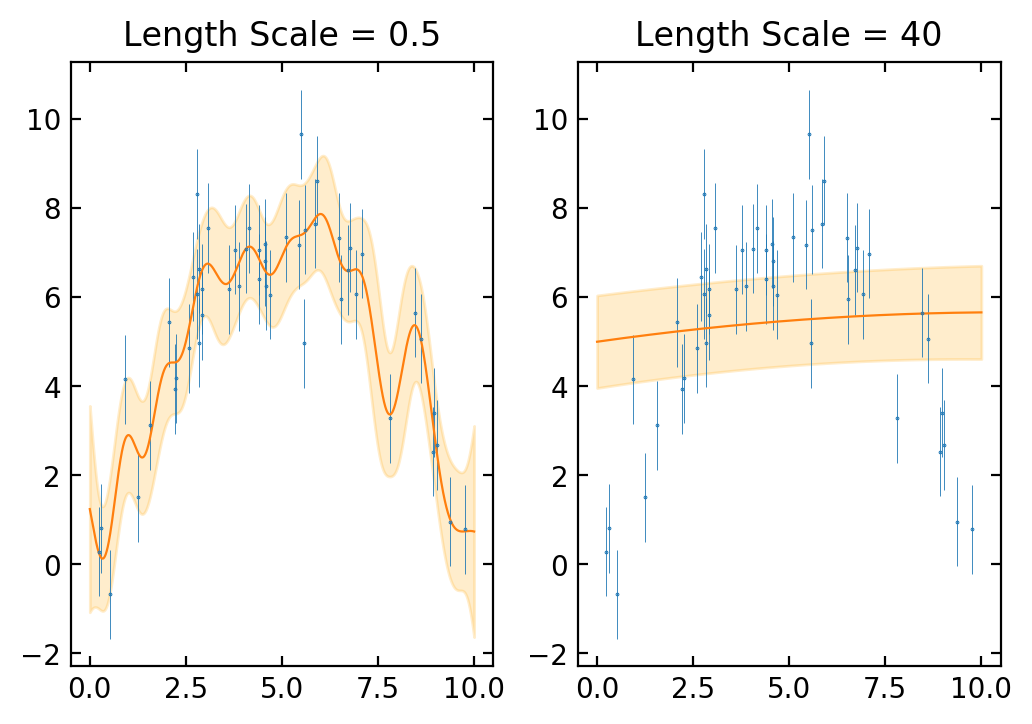

In [50]:
x_max = 10
errs = 1

def f(x, with_noise=True):
    np.random.seed(2)
    tmp = 3*x - 0.3*x**2
    if not with_noise: return tmp
    
    tmp += np.random.normal(scale=errs, size=x.shape)
    return tmp #- np.mean(tmp) # zero center

_, axes = plt.subplots(1, 2)
np.random.seed(3)
train_x = np.expand_dims(np.sort(np.random.random(size=50) * x_max), 1)
test_x = np.expand_dims(np.linspace(0, x_max, 2000), 1)

# Now GP model on this
for i, (var, ls) in enumerate([(30, 0.5), (30, 40)]):
    axes[i].errorbar(train_x, f(train_x), yerr=errs, ls="", marker=".", markersize=0.7, linewidth=0.3)

    k = GPy.kern.RBF(1, variance=var, lengthscale=ls)
    m = GPy.models.GPRegression(train_x, f(train_x), k)
    
    test_y, var_test_y = m.predict(test_x)
    axes[i].plot(test_x, test_y)
    axes[i].fill_between(test_x.flatten(), (test_y - np.sqrt(var_test_y)).flatten(), (test_y + np.sqrt(var_test_y)).flatten(), color="orange", alpha=0.2)
    axes[i].set(title="Length Scale = {}".format(ls))

Optimization restart 1/10, f = 84.34258292812956
Optimization restart 2/10, f = 84.34258292927551
Optimization restart 3/10, f = 84.34258292806113
Optimization restart 4/10, f = 84.34258292836006
Optimization restart 5/10, f = 84.34258292817427
Optimization restart 6/10, f = 84.34258293082848
Optimization restart 7/10, f = 84.34258292954067
Optimization restart 8/10, f = 84.34258293095697
Optimization restart 9/10, f = 84.34258292806282
Optimization restart 10/10, f = 84.34258298953291


[Text(0.5,1,'LS = 5.55, Var = 7.26')]

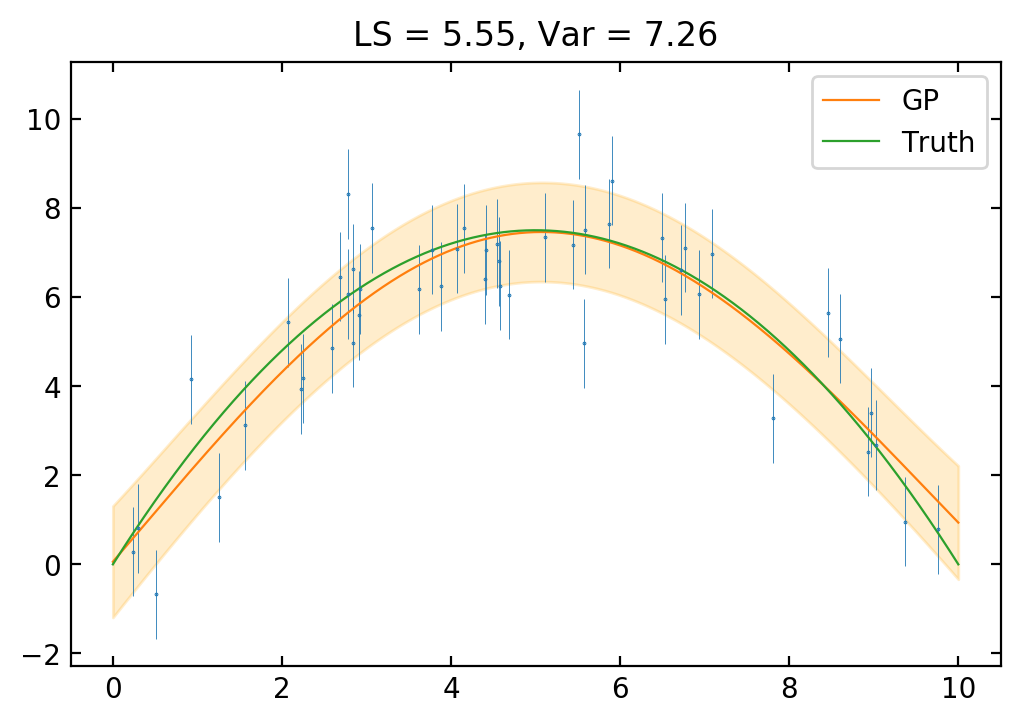

In [58]:
# The previous plots are both obviously bad.
k = GPy.kern.RBF(1, variance=0.1, lengthscale=5) # Give some initial values
m = GPy.models.GPRegression(train_x, f(train_x), k)
m.optimize(messages=True) # but then optimize
m.optimize_restarts(num_restarts = 10)

test_y, var_test_y = m.predict(test_x)

_, ax = plt.subplots()
ax.errorbar(train_x, f(train_x), yerr=errs, ls="", marker=".", markersize=0.7, linewidth=0.3)
ax.plot(test_x, test_y, label="GP")
ax.plot(test_x, f(test_x, with_noise=False), label="Truth")
ax.fill_between(test_x.flatten(), (test_y - np.sqrt(var_test_y)).flatten(), (test_y + np.sqrt(var_test_y)).flatten(), color="orange", alpha=0.2)
ax.legend()
ax.set(title="LS = {:.2f}, Var = {:.2f}".format(m.param_array[1], np.sqrt(m.param_array[0])))